<a href="https://www.kaggle.com/code/jorgegonzalezs/headpose-detection-mobilenet?scriptVersionId=100675965" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Head Pose Detector whit MobileNet

El objetivo de este cuaderno es detectar dónde está mirando una persona fijándose en una foto de su cara.
Para ello, se utilizará el Dataset que se puede encontrar en http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz

The objective of this notebook is to detect where a person is looking by looking at a picture of his or her face. 
To do so, we will use the dataset that can be found at: http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz

### 0. Importación de librerías
### 0. Import of libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import re
import requests
import glob
from tensorflow.keras import layers

### 1. Descarga de Dataset: Head Pose Image Database (Gourier, Hall, & Crowley, 2004)

Lo siguiente es descargar el dataset de http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz y estructurar los datos para dejarlos listos para su uso (descompresión del archivo tar.gz, creación de variables, tratamiento de expresiones regulares ...).

La información relevante a la construcción del dataset se puede encontrar en http://crowley-coutaz.fr/Head%20Pose%20Image%20Database.html

### 1. Dataset download: Head Pose Image Database (Gourier, Hall, & Crowley, 2004)
The next step is to download the dataset from http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz and structure the data to make it ready for use (unzipping the tar.gz file, creating variables, processing regular expressions ...).

Information relevant to the construction of the dataset can be found at http://crowley-coutaz.fr/Head%20Pose%20Image%20Database.html.

##### 1.1 Descarga y tratamiento como archivo
##### 1.1 Downloading and processing as an archive

In [2]:
import requests
url = 'http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz'
name = 'HeadPoseImageDatabase.tar.gz'
r = requests.get(url, allow_redirects=True)
open(name, 'wb').write(r.content)

28512828

##### 1.2 Descomprime del archivo tar.gz, usando el Linux que hay debajo de Jupyter Notebook, mediante el comando tar
##### 1.2 Unzip the tar.gz file, using the Linux under Jupyter Notebook, by using the tar command

In [3]:
!tar xfz HeadPoseImageDatabase.tar.gz

#### Formato del archivo:
Recordad que en el enlace de información se describe cómo está guardada la información, estando en cada archivo de la imagen los ángulos de inclinación y giro (tilt,pan) y las coordenadas de la cara (x,y), altura y anchura (h,w) dentro del archivo.

#### File format: 
Remember that the information link describes how the information is stored, being in each image file the tilt and rotation angles (tilt,pan) and the coordinates of the face (x,y), height and width (h,w) within the file.

##### 1.3 Tratamiento de las expresiones regulares de los títulos de las imágenes para conseguir las caracteristicas
##### 1.3 Processing of the regular expressions of the image titles to obtain the characteristics of the images.

In [4]:
def img_df(image_path, shape):
    image = Image.open(image_path)
    image_resized = image.resize(shape, Image.ANTIALIAS)
    img_array = np.asarray(image_resized)
    return img_array

### PASOS:
##### 1. Tienes que leer la información del archivo '.txt' para cada dato y guardarlo
##### 2. Tienes que incluir el "Tilt" y "Pan" que se puede extraer del nombre del archivo (con unos trucos de regex)
##### 3. Finalmente, hay que leer las imagenes '.jpg' para cada dato - que corresponde a su tilt, pan, X, Y, Height y Width. 
##### 3a. NO TE OLVIDES DE TRANSFORMAR LAS IMAGENES CON LA FUNCIÓN 'IMG_DF' ARRIBA

#### 2 Formas de hacerlo:

#### FORMA 1:

-------------------------

### STEPS/ STEPS:
##### 1. You have to read the information from the '.txt' file for each data and save it.
##### 2. You have to include the 'Tilt' and 'Pan' that can be extracted from the filename (with some regex tricks)
##### 3. Finally, you have to read the '.jpg' images for each data - corresponding to its tilt, pan, X, Y, Height and Width. 
##### 3a. DO NOT FORGET TO TRANSFORM THE IMAGES WITH THE FUNCTION 'IMG_DF' ABOVE

#### 2 Ways to do it:

#### WAY 1:


In [5]:
data = []
name = []
X = []
Y = []
W = []
H = []
T = []
P = []
imagen = []
for text in glob.glob("Person*/*txt"):
  name.append(text[0][0])
  imagen.append(img_df(text[:-3] + 'jpg',(224,224)))
  data = pd.read_csv(text, header = None)
  num = (re.findall(r'(\W\d+)', data[0][0])) # aplicamos esto para buscar todas las coincidencias de esas expresiones regulares
  T.append(int(num[0]))
  P.append(int(num[1]))
  X.append(int(data[0][2]))
  Y.append(int(data[0][3]))
  W.append(int(data[0][4]))
  H.append(int(data[0][5]))
# #print(data)
#pd.read_csv('Person10/person10270+30-30.txt', header = None)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df = pd.DataFrame()
df['X'] = X
df['Y'] = Y
df['H'] = H
df['W'] = W
df['T'] = T
df['P'] = P
df['Image'] = imagen
df.head()

,X,Y,H,W,T,P,Image
0,196,84,104,94,15,-45,"[[[22, 21, 19], [17, 16, 14], [54, 53, 51], [1..."
1,153,72,93,102,30,15,"[[[21, 21, 19], [15, 15, 13], [53, 53, 51], [1..."
2,116,42,73,83,30,75,"[[[18, 22, 23], [11, 15, 16], [51, 55, 56], [1..."
3,182,66,99,99,0,0,"[[[21, 21, 23], [15, 15, 17], [54, 54, 56], [1..."
4,231,83,96,78,15,-90,"[[[21, 21, 21], [15, 15, 15], [54, 54, 54], [1..."


#### Forma 2: y la que usaremos

----------

#### WAY 2: and the one we will use

In [7]:
# Creamos el datafreame donde cargaremos los datos extraidos de cada archivo (nombre del archivo y contenidos)
# We create the datafreame where we will load the data extracted from each file (file name and contents)
dt= pd.DataFrame()
# Creamos la lista de expresiones regulares que vamos a necesitar
# We create the list of regular expressions that we are going to need
regexp= r'(\W\d+)(\W\d+)' 
# Aquí usamos dos parentesis porque en expresiones regulares, cuando definimos parentesis, definimos grupos de busqueda. Con \W estamos buscando cualquier caracter que no sea una palabra
# Here we use two brackets because in regular expressions, when we define brackets, we define search groups. With \W we are looking for any character that is not a word.

### Matches any single letter, number or underscore (same as [a-zA-Z0-9_] )

### d+ seguido de uno o varios digitos
### d+ followed by one or more digits

# Dígito (un carácter en el rango 0-9), y +significa 1 o más veces. Por lo tanto, \d+es de 1 o más dígitos.
# Digit (a character in the range 0-9), and +means 1 or more times. Therefore, +is 1 or more digits.

# Creamos la lista vacia donde se almacenaran las imagenes jpg
# We create the empty list where the jpg images will be stored.
jpg_list=[]
image = []
# El bucle que viene a continuacion hace lo siguiente:
# The following loop does the following:
for txt_path in glob.glob("Person*/*txt"): # para cada ruta de txt, recorremos con GLOB todo lo que tenemos en el sistema de archivos
                                           # con esos parametros de busqueda (empiezan con person y son TXT) de esta forma tenemos  
                                           # la ruta completa a cada fichero TXT
                                           # for each txt path, we go through with GLOB everything we have in the file system
                                           # with those search parameters (they start with person and are TXT) so that we get  
                                           # the complete path to each TXT file
    jpg_path = txt_path[:-3] + "jpg"       # obtenemos la ruta para el JPG unicamente cogiendo la ruta del TXT
                                           # eliminando los ultimos 3 caracteres y poniendo JPG
                                           # we obtain the path for the JPG only by taking the path from the TXT
                                           # deleting the last 3 characters and putting JPG
    jpg_list.append(jpg_path)              # lo añadimos a la lista que antes hemos creado con las rutas de las imagenes
                                           # we add it to the list we created before with the image paths
    
    image.append(img_df(text[:-3] + 'jpg',(224,224)))

    dt = dt.append(pd.read_csv(txt_path, header=None).T) # recogemos los datos en un dataframe. Se usa la funcion de lectura CSV
                                                        # aunque no es un CSV, porque asi se almacena de una forma comoda.
                                                        # hacemos un transpose tambien para tenerlo en una linea 
                                                        # We collect the data in a dataframe. The CSV read function is used
                                                        # although it is not a CSV, because it is stored in a convenient way.
                                                        # we make a transpose also to have it in one line.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
dt = dt.drop(1, axis=1) # Borramos la primera columna porque solo pone "face"
                        # We delete the first column because it only says "face".
dt["T"] = dt[0].apply(lambda cell: int(re.findall(regexp, cell)[0][0]))
dt["P"] = dt[0].apply(lambda cell: int(re.findall(regexp, cell)[0][1]))
dt["Image_path"] = jpg_list

# En la fila siguiente se va a utilizar la funcion que habiamos creado anteriormente "img_df" que tiene dos argumentos: la ruta y el tamaño
## -> Ruta: la ruta de cada archivo que va a ser redimensionado esta en la columna dt['Image_path'], con la funcion lambda se escribe de esta forma
## -> Tamaño: el tamaño elegido es 224x224 por la entrada de mobilenet

# In the next row we are going to use the function that we created earlier "img_df" which has two arguments: the path and the size.
## -> Path: the path of each file to be resized is in the column dt['Image_path'], with the lambda function it is written like this
## -> Size: the size chosen is 224x224 for the mobilenet input.
dt["Image"] = dt['Image_path'].apply(lambda img: img_df(img, (224, 224)))
dt = dt.drop([0, "Image_path"], axis=1)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Comprobamos que el Dataframe esta bien
# We check that the Dataframe is OK
dt.head()

,2,3,4,5,T,P,Image
0,196,84,94,104,15,-45,"[[[22, 21, 19], [17, 16, 14], [54, 53, 51], [1..."
0,153,72,102,93,30,15,"[[[21, 21, 19], [15, 15, 13], [53, 53, 51], [1..."
0,116,42,83,73,30,75,"[[[18, 22, 23], [11, 15, 16], [51, 55, 56], [1..."
0,182,66,99,99,0,0,"[[[21, 21, 23], [15, 15, 17], [54, 54, 56], [1..."
0,231,83,78,96,15,-90,"[[[21, 21, 21], [15, 15, 15], [54, 54, 54], [1..."


In [10]:
# Renombramos las columnas y marcamos que los datos son INT
# Rename the columns and mark that the data is INT
dt.columns = ["X", "Y", "H", "W", "T", "P", "Image"]
dt.X = dt.X.astype(int)
dt.Y = dt.Y.astype(int)
dt.H = dt.H.astype(int)
dt.W = dt.W.astype(int)
dt.P = dt.P.astype(int)
dt = dt.reset_index().drop("index", axis=1)


In [11]:
# Comprobamos que los cambios se han producido
# We check that the changes have taken place
dt.head()

,X,Y,H,W,T,P,Image
0,196,84,94,104,15,-45,"[[[22, 21, 19], [17, 16, 14], [54, 53, 51], [1..."
1,153,72,102,93,30,15,"[[[21, 21, 19], [15, 15, 13], [53, 53, 51], [1..."
2,116,42,83,73,30,75,"[[[18, 22, 23], [11, 15, 16], [51, 55, 56], [1..."
3,182,66,99,99,0,0,"[[[21, 21, 23], [15, 15, 17], [54, 54, 56], [1..."
4,231,83,78,96,15,-90,"[[[21, 21, 21], [15, 15, 15], [54, 54, 54], [1..."


##### 1.4 Separado en X (datos) e Y (a predecir) y su normalización
##### 1.4 Separated into X (data) and Y (to be predicted) and their normalization

In [12]:
# Dividimos por 255 para normalizar los datos.
# We divide by 255 to normalize the data.
X = np.asarray(list(dt["Image"]/255.)) 
# Los datos de salida los dividimos por 100 porque la red neuronal podra usar valores mas ajustados a 1 y asi no seran calculos tan grandes
# The output data is divided by 100 because the neural network will be able to use values closer to 1 and so the calculations will not be so large.
Y = np.array(dt[["X", "Y", "H", "W", "T", "P"]])/100.

##### 1.5 Split de conjuntos finales de x_train, y_train, x_test y y_test

In [13]:
# Definimos el Random State y el Test Size aparte, por si acaso en algun futuro queremos ajustarlos de otra forma.
# We define the Random State and Test Size separately, in case we want to adjust them differently in the future.
my_random_state= 42
my_test_size= 0.33

In [14]:
# Hacemos una division para tener, primero, las divisiones de entrenamiento y test y luego en la segunda, para validacion
# We make a division to have, first, the training and test divisions and then in the second one, for validation.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=my_test_size, 
    random_state=my_random_state)

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X_train, Y_train, 
    test_size=my_test_size, 
    random_state=my_random_state
)

In [15]:
# Comprobamos los tamaños de cada elemento
# We check the sizes of each element
display(f"TRAIN SHAPES: X:{X_train.shape}  Y:{Y_train.shape}")
display(f"TEST  SHAPES: X:{X_test.shape}  Y:{Y_test.shape}")
display(f"VALIDATION  SHAPES: X:{X_validation.shape}  Y:{Y_validation.shape}")

'TRAIN SHAPES: X:(1252, 224, 224, 3)  Y:(1252, 6)'

'TEST  SHAPES: X:(921, 224, 224, 3)  Y:(921, 6)'

'VALIDATION  SHAPES: X:(617, 224, 224, 3)  Y:(617, 6)'

In [16]:
# Comprobamos que sean arrays de numpy
# We check that they are numpy arrays
display(f"X es un {type(X_train)} con un tamaño de: {X_train.shape}")
display(f"Y es un {type(Y_train)} con un tamaño de: {Y_train.shape}")

display(f"X is a {type(X_train)} with a size of: {X_train.shape}")
display(f"Y is a {type(Y_train)} with a size of: {Y_train.shape}")

"X es un <class 'numpy.ndarray'> con un tamaño de: (1252, 224, 224, 3)"

"Y es un <class 'numpy.ndarray'> con un tamaño de: (1252, 6)"

"X is a <class 'numpy.ndarray'> with a size of: (1252, 224, 224, 3)"

"Y is a <class 'numpy.ndarray'> with a size of: (1252, 6)"

### 2 Importado de red neuronal MobileNet sin incluir la última capa
El objetivo aquí es importar la red neuronal MobileNet (una arquitectura que ha demostrado ser bastante eficiente para este problema) excluyendo la última capa. Con ello, descartaremos la última capa, para posteriormente crearla nosotros y concatenar las dos partes.

### 2 Imported from MobileNet neural network without including the last layer
The objective here is to import the MobileNet neural network (an architecture that has proven to be quite efficient for this problem) excluding the last layer. In doing so, we will discard the last layer, and then create it ourselves and concatenate the two parts.

##### 2.1 Importar la red de Keras sin la última capa
##### 2.1 Import Keras network without the last layer

In [17]:
# Definimos el numero de clases de nuestro modelo:
# We define the number of classes of our model:
n_clases = Y.shape[-1]

# podriamos poner un numero 6 directamente, pero mejor tomar el numero de categorias que tiene Y de esa forma
# we could put a number 6 directly, but better to take the number of categories that Y has that way

In [18]:
# Mas librerias
# More libreries
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.models      import Sequential
from tensorflow.keras.layers      import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.losses      import CosineSimilarity
from tensorflow.keras.metrics     import RootMeanSquaredError
from keras.preprocessing import image
from keras.models import Model


In [19]:
#Importamos mobilenet quitando su output y con un tamaño de input que antes ya habiamos definido
#Import mobilenet by removing its output and with an input size that we have already defined.

base_model = tf.keras.applications.MobileNet(weights='imagenet',input_shape= (224,224,3),include_top=False)  


2022-07-12 23:29:54.466266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 23:29:54.594746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 23:29:54.595787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 23:29:54.597521: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
# Comprobamos que lo hemos importado correctamente. Se puede ver que la primera capa esta importada con el input (224,224,3)
# We check that we have imported it correctly. You can see that the first layer is imported with the input (224,224,3)
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

##### 2.2 Crear nuestra última capa
##### 2.2 Create our last layer

In [21]:
# Tenemos que crear una ultima capa que nos dé nuestra salida, clasificado en 6 clases que le hemos marcado.
# We have to create a last layer that gives us our output, classified in 6 classes that we have marked.
x = base_model.output
# Añadimos una capa de pooling 
# Add a layer of pooling 
x = GlobalAveragePooling2D()(x)
# Añadimos capas Densas para que el modelo pueda aprender funciones mas complejas y clasificar mejor
# We add Dense layers so that the model can learn more complex functions and classify better.
x = Dense(1024,activation='relu')(x) # dense layer 1 con 1024 neuronas
                                    # dense layer 1 with 1024 neurons
x = Dense(1024,activation='relu')(x) # dense layer 2 con 1024 neuronas
                                    # dense layer 1 with 1024 neurons
x = Dense(512,activation='relu')(x) # dense layer 3 con 512 neuronas
                                    # dense layer 1 with 512 neurons

# IMPORTANTE->A la ultima le damos una activacion lineal porque no estamos ante un problema de clasificacion. 
# Queremos obtener un valor linear relacionado con el valor del angulo de donde esta girada la cara

# IMPORTANT->To the last one we give a linear activation because we are not facing a classification problem. 
# We want to obtain a linear value related to the value of the angle where the face is rotated.

preds = Dense(n_clases,activation='linear')(x)
# Juntamos el modelo
# We join the model
model= tf.keras.Model(inputs= base_model.input, outputs=preds)

In [22]:
# Comprobamos cuantos layers tenemos
# We check how many layers we have
len(base_model.layers)

86

##### 2.3 Juntar la red y la capa
##### 2.3 Joining the network and the layer

In [23]:
# Juntamos el modelo
# We join the model
#model= tf.keras.Model(inputs= base_model.input, outputs=preds)

# Ahora tenemos que congelar las capas para definir cuales capas se va a entrenar y cuales capas vas a dejar con su entrenamiento anterior.
# Now we have to freeze the layers to define which layers you are going to train and which layers you are going to leave with their previous training.

# Cuantas congelar o no congelar, depende un poco del ojo del programador.
# How many to freeze or not to freeze, depends a little on the eye of the programmer.
for layer in model.layers[:20]:
  layer.trainable= False
for layer in model.layers[20:]:
  layer.trainable= True

In [24]:
# Comprobamos que efectivamente antes teniamos 86 y ahora tenemos mas layers. 
# We checked that indeed before we had 86 and now we have more layers.
len(model.layers)


91

##### 2.4 Compilar (elegir optimizador, funcion de perdida(loss) y métrica de error)
##### 2.4 Compile (choose optimizer, loss function and error metrics)

In [25]:
# Definimos Adam como optimizador con una learning rate de 0.0001
# Además, elegimos mean squared error para medir la pérdida y cosine proximity como métrica

# We define Adam as an optimizer with a learning rate of 0.0001
# In addition, we choose mean squared error to measure the loss and cosine proximity as a metric.
optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(optimizer = optimizer,
              loss ='mean_squared_error',
              metrics = ['cosine_proximity'])

##### 2.5 Entrenar la red que hemos importado y manipulado, con el dataset que hemos tratado
##### 2.5 Train the network we have imported and manipulated, with the dataset we have processed

In [26]:
# Entrenamiento
# Train
hist = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=12, verbose=1)


2022-07-12 23:29:59.288986: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 753844224 exceeds 10% of free system memory.
2022-07-12 23:30:00.201876: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 753844224 exceeds 10% of free system memory.
2022-07-12 23:30:00.878036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2022-07-12 23:30:05.381768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 [==============================] - 16s 124ms/step - loss: 0.1680 - cosine_proximity: 0.9383 - val_loss: 0.3360 - val_cosine_proximity: 0.9697
Epoch 2/12
40/40 [==============================] - 3s 78ms/step - loss: 0.0239 - cosine_proximity: 0.9930 - val_loss: 0.2470 - val_cosine_proximity: 0.9790
Epoch 3/12
40/40 [==============================] - 3s 85ms/step - loss: 0.0163 - cosine_proximity: 0.9950 - val_loss: 0.1318 - val_cosine_proximity: 0.9862
Epoch 4/12
40/40 [==============================] - 3s 75ms/step - loss: 0.0127 - cosine_proximity: 0.9962 - val_loss: 0.1036 - val_cosine_proximity: 0.9896
Epoch 5/12
40/40 [==============================] - 3s 72ms/step - loss: 0.0123 - cosine_proximity: 0.9964 - val_loss: 0.0370 - val_cosine_proximity: 0.9927
Epoch 6/12
40/40 [==============================] - 3s 78ms/step - loss: 0.0108 - cosine_proximity: 0.9968 - val_loss: 0.0339 - val_cosine_proximity: 0.9935
Epoch 7/12
40/40 [==============================] - 3s 76ms/step - 

Ahora creamos una función que nos permita graficar nuestros resultados.

Now we create a function that allows us to plot our results.

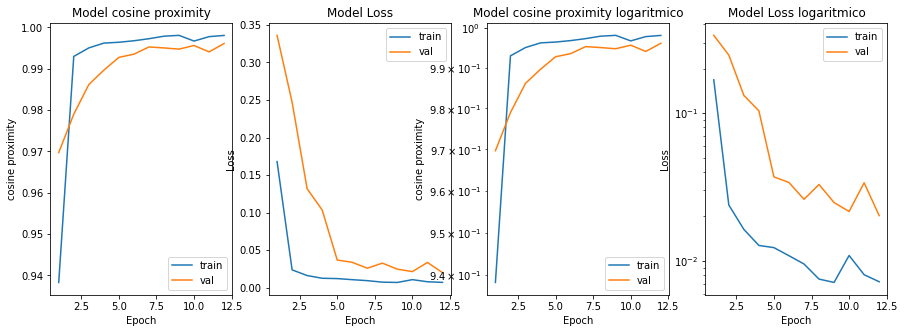

In [27]:
import matplotlib.pyplot as plt
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,4,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['cosine_proximity'])+1),model_history.history['cosine_proximity'])
    axs[0].plot(range(1,len(model_history.history['val_cosine_proximity'])+1),model_history.history['val_cosine_proximity'])
    axs[0].set_title('Model cosine proximity')
    axs[0].set_ylabel('cosine proximity')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['cosine_proximity'])+1),len(model_history.history['cosine_proximity'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    #### ESCALA LOGARITMICA ####
    # accuracy
    axs[2].plot(range(1,len(model_history.history['cosine_proximity'])+1),model_history.history['cosine_proximity'])
    axs[2].plot(range(1,len(model_history.history['val_cosine_proximity'])+1),model_history.history['val_cosine_proximity'])
    axs[2].set_title('Model cosine proximity logaritmico')
    axs[2].set_ylabel('cosine proximity')
    axs[2].set_xlabel('Epoch')
    axs[2].set_yscale('log')
    #axs[2].set_xticks(np.arange(1,len(model_history.history['cosine_proximity'])+1),len(model_history.history['cosine_proximity'])/10)
    axs[2].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[3].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[3].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[3].set_title('Model Loss logaritmico')
    axs[3].set_ylabel('Loss')
    axs[3].set_xlabel('Epoch')
    axs[3].set_yscale('log')
    #axs[3].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[3].legend(['train', 'val'], loc='best')
    plt.show()

    
# Graficamos
# We plot
plot_model_history(hist)

##### 2.6 Visualizar un diagrama de correlación entre los valores predichos y los valores que debieran ser (usando por ejemplo el RMSE o R2 dado por sklearn)
##### 2.6 Display a correlation diagram between the predicted values and the values that should be (using for example the RMSE or R2 given by sklearn).

In [28]:
#Creamos un dataframe para los valores reales del test set y otro con las predicciones. De esta manera, nos resultará más fácil calcular las métricas que aplicamos para estudiar el funcionamiento del modelo.
true_df = pd.DataFrame(Y_test)
true_df.columns = ["X", "Y", "H", "W", "T", "P"]
true_df.head()


,X,Y,H,W,T,P
0,1.28,1.12,1.13,1.14,0.30,0.30
1,1.52,1.84,1.41,1.43,-0.30,0.15
2,1.06,1.16,1.09,1.21,0.60,0.75
3,1.18,1.98,1.03,1.02,-0.60,0.15
4,1.33,1.26,1.03,1.01,-0.15,0.15


In [29]:
y_pred = model.predict(X_test)
pred_df = pd.DataFrame(y_pred)
pred_df.columns = ["X", "Y", "H", "W", "T", "P"]
pred_df.head()

2022-07-12 23:31:27.868955: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 554545152 exceeds 10% of free system memory.
2022-07-12 23:31:28.595404: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 554545152 exceeds 10% of free system memory.


,X,Y,H,W,T,P
0,1.217972,1.157180,1.178261,1.189981,0.180267,0.207076
1,1.693392,2.112562,1.454454,1.565179,-0.217578,0.085410
2,1.112400,1.347954,1.180838,1.181821,0.596183,0.791896
3,1.345176,2.137939,1.230973,1.144301,-0.516569,0.242061
4,1.593670,1.514906,1.118836,1.175903,-0.075173,0.239875


Los resultados obtenidos sobre el test set son bastante buenos, sobre todo si nos fijamos en X,Y, tilt y pan, que son las variables más relevantes en este problema.
También hemos visualizado los valores reales vs los predicted por nuestra red.

The results obtained on the test set are quite good, especially if we look at X,Y, tilt and pan, which are the most relevant variables in this problem.
We have also visualized the real values vs. those predicted by our network.

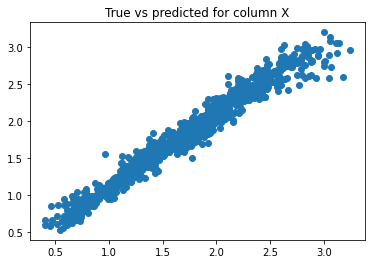

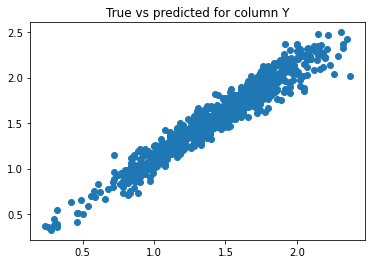

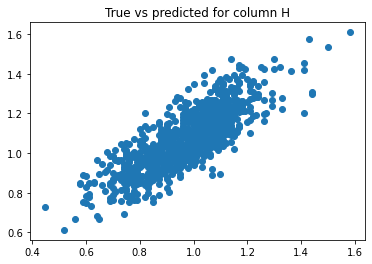

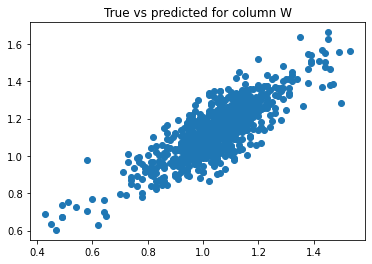

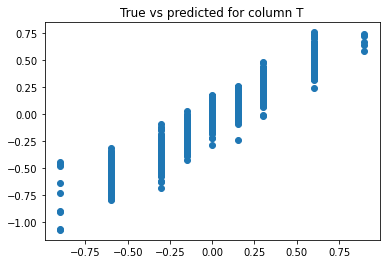

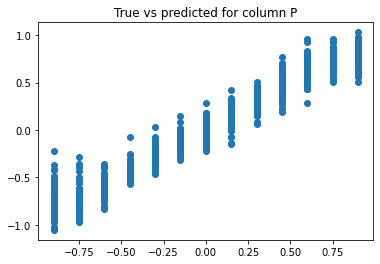

In [30]:
for col in true_df.columns:
  plt.scatter(true_df[col], pred_df[col])
  plt.title("True vs predicted for column " + col)
  plt.show()

In [31]:
from sklearn.metrics import mean_squared_error as mse
from scipy import spatial
metrics = []
for col in true_df.columns:
  rmse = mse(true_df[[col]], pred_df[[col]], squared=True)
  r2 = r2_score(true_df[[col]], pred_df[[col]])
  cosine = 1 - spatial.distance.cosine(true_df[[col]], pred_df[[col]])
  metrics.append([rmse, r2, cosine])

metrics_df = pd.DataFrame(metrics)
metrics_df.columns =  ['rmse', 'r2', 'cosine']
metrics_df.index = ['X', 'Y', 'H', 'W', 'T', 'P']
metrics_df

,rmse,r2,cosine
X,0.024546,0.936009,0.997643
Y,0.025706,0.822973,0.997999
H,0.018834,0.184152,0.995953
W,0.015116,0.196180,0.997024
T,0.012663,0.911764,0.955023
P,0.015086,0.951753,0.975846


In [32]:
model.save('my_model_trasnfer_MobileNet.h5')